In [1]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
%matplotlib inline

Then, let's specify a specific DICOM study we can take a closer look. Let's take a look at a chest CT stack which contains a lung cancer.

The whole dataset is 100GB unzipped, but each examination is only 100MB or so.

Here we'll use the patient ID CT-Training-lc008 from that dataset, which has been labeled as positive for lung cancer.

In [2]:
data_path = "C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17"
output_path = "C:/Users/s57kumar/Desktop/inputimagedata/outputimage/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 376 DICOM images.
First 5 filenames:
C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17\000000.dcm
C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17\000001.dcm
C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17\000002.dcm
C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17\000003.dcm
C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-LC008/01-10-2007-6844-CT NON-INFUSED CHEST-595.1/4-HIGH RES-02.17\000004.dcm


## Helper Functions

Here we make two helper functions.

load_scan will load all DICOM images from a folder into a list for manipulation.
The voxel values in the images are raw. get_pixels_hu converts raw values into Houndsfeld units
The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).

In [4]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    print(len(image))
    print(image[image == -2000])
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [6]:
# processing second patient which is sespected for primary lung cancer
id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\filereader.py:313: UserWarning:

Expected explicit VR, but found implicit VR - using implicit VR for reading



376
[]


#### save the new data set to disk so we don't have to reprocess the stack every time.

In [6]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

In [7]:
path1 = "C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/LUNGx-CT051/01-13-2007-794-CT INFUSED CHEST-32081/4-HIGH RES-64483"
path2 ="C:/Users/s57kumar/Desktop/inputimagedata/SPIE-AAPM Lung CT Challenge/CT-Training-BE007/02-13-2007-18066-CT INFUSED CHEST-000.1/5-HIGH RES-89.27"

In [13]:
# processing second patient which is also sespected for primary lung cancer
id=1
patient = load_scan(path1)
imgs = get_pixels_hu(patient)
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\filereader.py:313: UserWarning:

Expected explicit VR, but found implicit VR - using implicit VR for reading



298
[]


In [12]:
# processing third patient which is not having lung cancer
id=2
patient = load_scan(path2)
imgs = get_pixels_hu(patient)
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

341
[]


### Displaying Images

The first thing we should do is to check to see whether the Houndsfeld Units are properly scaled and represented.

HU's are useful because it is standardized across all CT scans regardless of the absolute number of photons the scanner detector captured. If you need a refresher, here's a quick list of a few useful ones, sourced from Wikipedia.

Substance	HU

Air	−1000

Lung −500

Fat	−100 to −50

Water	0

Blood	+30 to +70

Muscle	+10 to +40

Liver	+40 to +60

Bone	+700 (cancellous bone) to +3000 (cortical bone)

Let's now create a histogram of all the voxel data in the study.

In [10]:
# function to draw histogram
def plothistogram(id):
    file_used=output_path+"fullimages_%d.npy" % id
    imgs_to_process = np.load(file_used).astype(np.float64) 

    plt.hist(imgs_to_process.flatten(), bins=50, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    

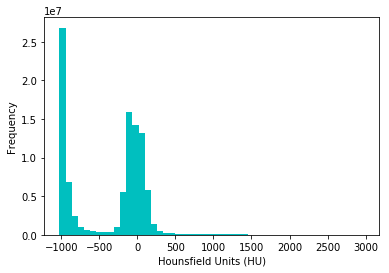

In [11]:
id=0
plothistogram(id)

The histogram suggests the following:

There is lots of air
There is some lung
There's an abundance of soft tissue, mostly muscle, liver, etc, but there's also some fat.
There is only a small bit of bone (seen as a tiny sliver of height between 700-3000)
This observation means that we will need to do significant preprocessing if we want to process lesions in the lung tissue because only a tiny bit of the voxels represent lung.

Air really only goes to -1000

Let's take a look at the actual images.

We don't have a lot of screen real estate, so we'll be skipping every 3 slices to get a representative look at the study.

In [14]:
def sample_stack(stack, rows=8, cols=8, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

In [7]:
id = 0
output_path = working_path = "C:/Users/s57kumar/Desktop/outputimage/"
test = np.load(output_path+'fullimages_{}.npy'.format(id))
test.shape

(376, 512, 512)

In [8]:
id = 1
output_path = working_path = "C:/Users/s57kumar/Desktop/outputimage/"
test = np.load(output_path+'fullimages_{}.npy'.format(id))
test.shape

(298, 512, 512)

In [9]:
id = 2
output_path = working_path = "C:/Users/s57kumar/Desktop/outputimage/"
test = np.load(output_path+'fullimages_{}.npy'.format(id))
test.shape

(341, 512, 512)

In [10]:
id = 3
output_path = working_path = "C:/Users/s57kumar/Desktop/outputimage/"
test = np.load(output_path+'fullimages_{}.npy'.format(id))
test.shape

(113, 512, 512)

In [6]:
test.shape

(376, 512, 512)

C:/Users/s57kumar/Desktop/inputimagedata/outputimage/fullimages_0.npy
No of slices  376


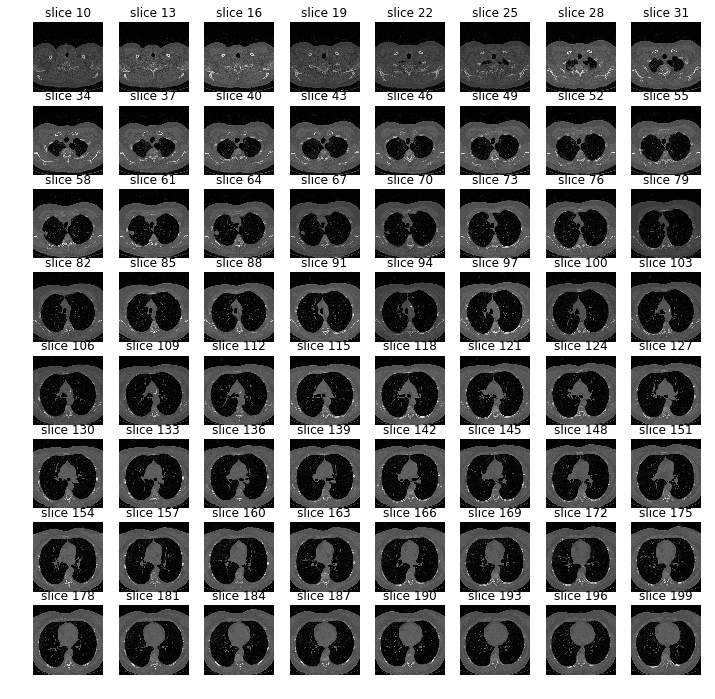

In [15]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
print (output_path+'fullimages_{}.npy'.format(id))
print ( "No of slices  " + str (len(imgs_to_process)))

sample_stack(imgs_to_process)

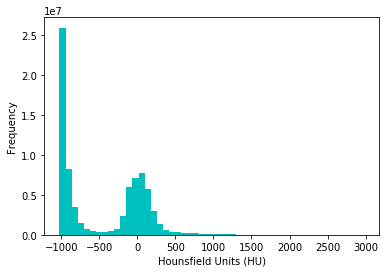

In [43]:
id=1
plothistogram(id)

C:/Users/s57kumar/Desktop/outputimage/fullimages_1.npy
No of slices  298


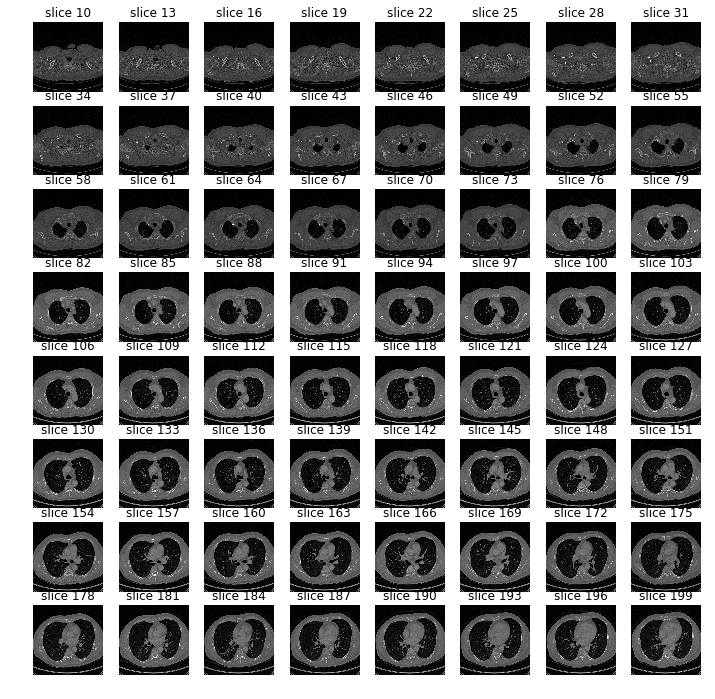

In [44]:
id = 1
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
print (output_path+'fullimages_{}.npy'.format(id))
print ( "No of slices  " + str (len(imgs_to_process)))

sample_stack(imgs_to_process)

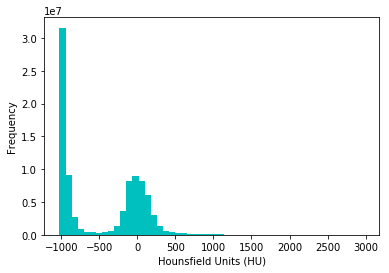

In [45]:
id=2
plothistogram(id)

C:/Users/s57kumar/Desktop/outputimage/fullimages_2.npy
No of slices  341


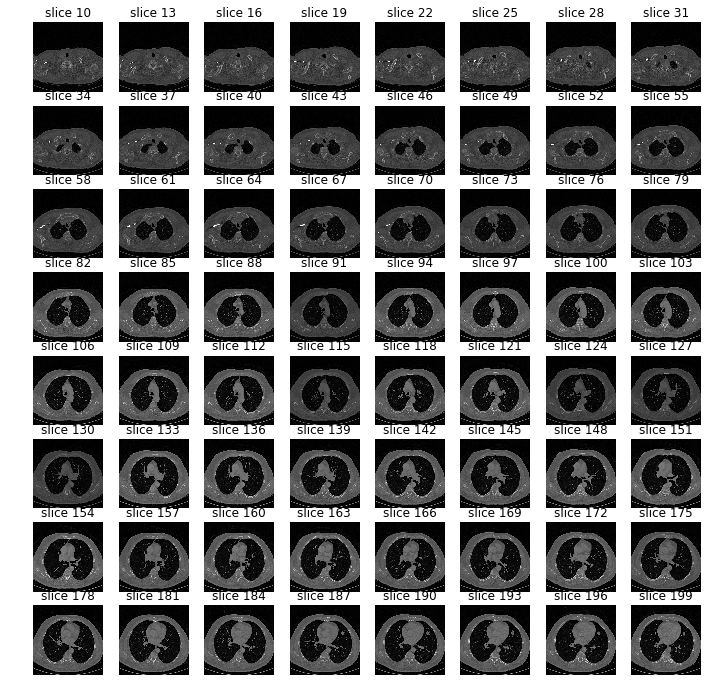

In [46]:
id = 2
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
print (output_path+'fullimages_{}.npy'.format(id))
print ( "No of slices  " + str (len(imgs_to_process)))

sample_stack(imgs_to_process)

In [56]:
path3 = "C:/Users/s57kumar/Desktop/NSCLC-Radiomics/LUNG1-083/12-31-2005-StudyID-78482/0-32652"

In [57]:
# processing fourth patient which is having lung cancer
id=3
patient = load_scan(path3)
imgs = get_pixels_hu(patient)
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

113
[]


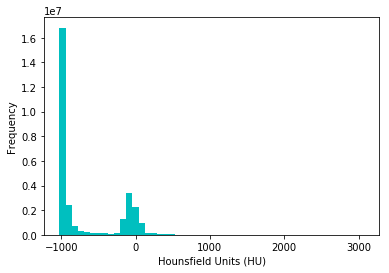

In [58]:
id=3
plothistogram(id)

C:/Users/s57kumar/Desktop/outputimage/fullimages_3.npy
No of slices  113


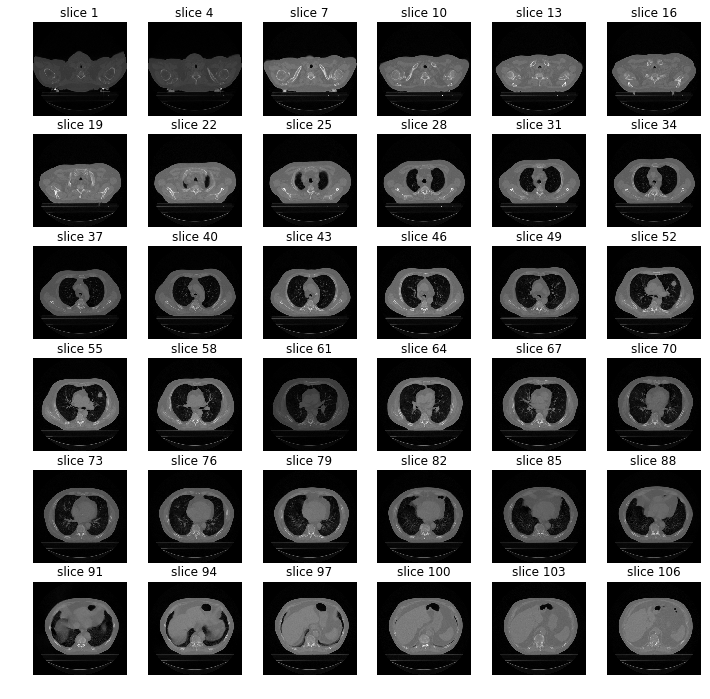

In [63]:
id = 3
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
print (output_path+'fullimages_{}.npy'.format(id))
print ( "No of slices  " + str (len(imgs_to_process)))

sample_stack(imgs_to_process,rows=6, cols=6, start_with=1)

"Air," in comparison, appears gray because it has a much higher value. As a result, the lungs and soft tissue have somewhat reduced contrast resolution as well.

We will try to manage this problem when we normalize the data and create segmentation masks.

## Resampling

Although we have each individual slices, it is not immediately clear how thick each slice is.

In [17]:
print ("Slice Thickness: %f" % patient[0].SliceThickness )
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.544922, 0.544922) 


This means we have 1.0 mm slices, and each voxel represents 0.54 mm.

For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Because a CT slice is typically reconstructed at 512 x 512 voxels, each slice represents approximately 370 mm of data in length and width.

Using the metadata from the DICOM we can figure out the size of each voxel as the slice thickness. In order to display the CT in 3D isometric form (which we will do below), and also to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.

In [7]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(scan[0].SliceThickness + scan[0].PixelSpacing[0], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

print( "Shape before resampling\t", imgs_to_process.shape)
#imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
##print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (376, 512, 512)


In [8]:
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])

In [9]:
print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape after resampling	 (581, 791, 791)


Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

### 3D plotting the scan
Having isotropic data is helpful because it gives us a sense of the Z-dimension. This means we now have enough information to plot the DICOM image in 3D space. For kicks we'll focus on rendering just the bones.

Visualization Toolkit (VTK) is excellent for 3D visualization because it can utilize GPU for fast rendering. However, I can't get VTK to work in Jupyter, so we will take a slightly different approach:

Create a high-quality static using 3D capability of matplotlib

we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

The marching cubes algorithm is used to generate a 3D mesh from the dataset. The plotly model will utilize a higher step_size with lower voxel threshold to avoid overwhelming the web browser.

In [43]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces , norm, val = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [44]:
# Our plot function takes a threshold argument which we can use to plot certain structures, such as all tissue or only the bones.
# 400 is a good threshold for showing the bones only (see Hounsfield unit table above).
plot_3d(imgs_after_resamp, 400)

KeyboardInterrupt: 

In [11]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor(0.7, 0.7, 0.7)
    plt.show()

In [ ]:
v, f = make_mesh(imgs_after_resamp, 400)
plt_3d(v, f)

Transposing surface
Calculating surface
Drawing


TypeError: set_facecolor() takes 2 positional arguments but 4 were given